# Tutorial for determining the parton content of the proton with a quantum computer


In this tutorial we will show how to use the `PDFModel` from qibo to create quantum Parton Distribution Functions (PDF). PDFs determine the content of the proton in terms of the particles of the Standard Model it is made of. In this work, we will simulate a quantum computer to encode within a circuit the data from these PDF in such a way that, if we measure the output of the aforementioned quantum circuit, we will obtain the composition of protons.

This achievement is accomplished via a Variational Quantum Circuit (VQC), see image below. 

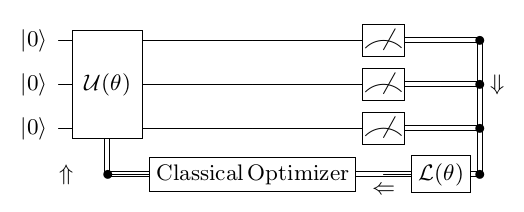

#### Circuit

The circuit we create to encode the PDFs are simple. We consider two different Ansätze, that are already implemented in Qibo. Those Ansätze depend on tunable parameters and a variable $x$ that also serves as the independent variables for the PDF $f_i(x, Q)$, where $Q$ is fixed. 

The first one is the Ansatz _Weighted_. Its basic single qubit gate is 

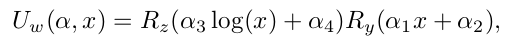

The second Ansatz is the fourier one, whose basic single-qubit gate is, on demand

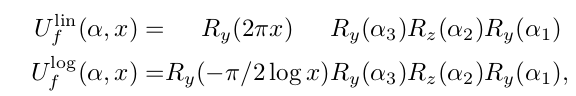

Both Ansätze have a layered structure with entangling gates among different qubits depicted in the following circuit

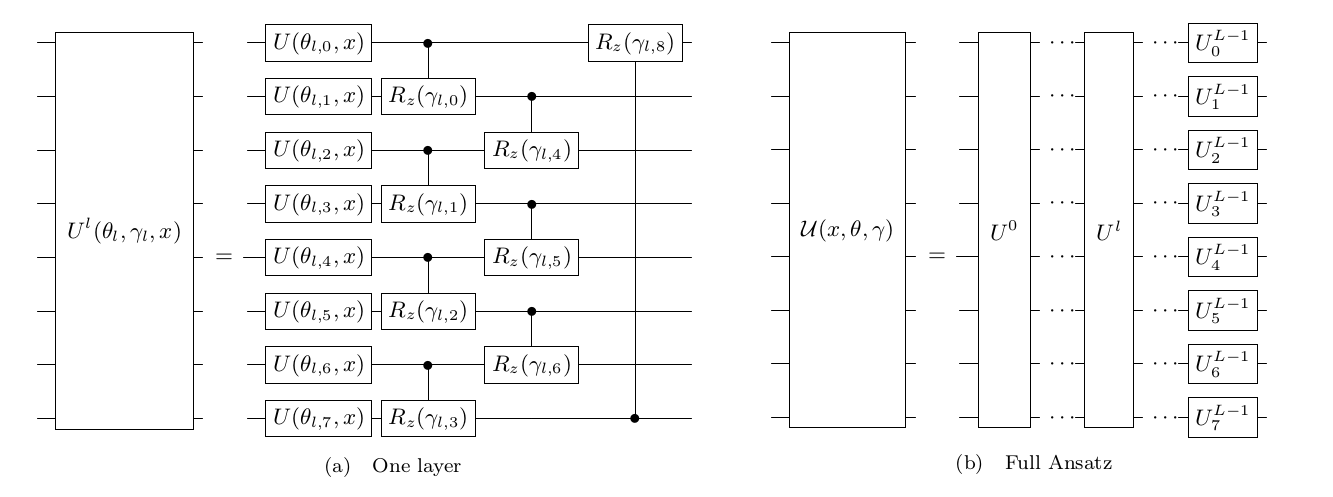

The Ansatz is constructed in one qubit per parton. We only let one and all flavours $(s, \bar s, c, u, \bar u, d, \bar d, g)$ to be optimized simultaneously, thus only circuits with one and eight qubits are available.

#### Cost function

The cost function driving the optimization process of this circuit is defined through several pieces. First, we need a Hamiltonian to measure. We choose a different hamiltonian for every parton, namely 

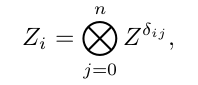

This family of hamiltonians allows for the definition of their expected values, depending on $\theta$ and $x$

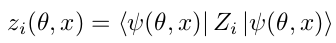

The relation between the $z(\theta, x)$ quantities and PDFs is

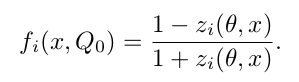

Using this definition, we can just use the usual Pearson's chi-squared quantity

$$
\chi^2 = \frac{1}{N}\sum_{i=1}^N \int_{x\in[0, 1]} dx \frac{\left( f_i (x, \theta) - \frac{1 - z(x, \theta)}{1 + z(x, \theta)}\right)^2}{\sigma^2}
$$

This is the loss function for our minimization procedure.

## Code

First, we must decide the variables for our problem. The meaning of them are
- `ansatz`: Which one is chosen, *Weighted* or *Fourier*
- `multi_output`: If *True*, all partons are fitted in the same circuit
- `parton`: which parton is to be fit. Ignored if `multi_output=True`
- `full`: if *True*, data is fitted for $x \in [10^{-4}, 1]$. Else, only large $x$ is considered
- `layers`: number of layers

In [1]:
from qibo.hep import qPDF
import numpy as np

ansatz = 'Weighted'
multi_output=True
parton='gluon'
full=True
layers=3


Extract reference data and auxiliary variables. These cell controls the importing of different sets of data.

In [2]:
#Select data
if multi_output:
    if full:
        data_file = 'data/full/8flavours.dat'

    else:
        data_file = 'data/partial/8flavours.dat'

    parton = '8flavours'
    nqubits = 8

else:
    if full:
        data_file = 'data/full/' + parton + '.dat'

    else:
        data_file = 'data/partial/' + parton + '.dat'
    parton = parton
    nqubits = 1

if full:
    folder = 'results/full/' + parton
else:
    folder = 'results/partial/' + parton
    
data = np.loadtxt(data_file)

mypdf = qPDF(ansatz, layers, nqubits, multi_output=multi_output)

Now we define a way to compute the loss function 

$$
\chi^2 = \frac{1}{N}\sum_{i=1}^N\sum_{j} \frac{\left( f_i (x_j, \theta) - \frac{1 - z(x_j, \theta)}{1 + z(x_j, \theta)}\right)^2}{\sigma^2}
$$

is defined. For multi-flavour fits, a mean is considered.

In [3]:
# Define loss function

def loss(params):
    """Get loss of the model for a given set of parameters.

    Args:
        parameters: the list of parameters for the gates

    Returns:
        Float, loss function
    """
    if multi_output:
        cf = 0
        xtrain = data[:, 0]
        i = 1
        for ypred in mypdf.predict(params, xtrain).transpose():
            ytrain = data[:, i]
            ysigma = data[:, i + 1]
            cf += np.mean(np.square(ytrain - ypred) / ysigma ** 2)
            i += 2
        cf /= 8

    else:
        xtrain = data[:, 0]
        ytrain = data[:, 1]
        ysigma = data[:, 2]

        ypred = mypdf.predict(params, xtrain).flatten()
        cf = np.mean(np.square(ytrain - ypred) / ysigma ** 2)


    return cf



Optimization procedure extracted from standard techniques must be used to look for the optimal configuration of $\theta$ parameters. In this case, we will implement optimizers from `scipy` and a genetic one. 

In [4]:
# For optimizing

def minimize(loss, params, sigma=1, method='L-BFGS-B', options=None):
    if method == 'cma':
        # Genetic optimizer
        import cma
        r = cma.fmin(loss, params, sigma, options=options)
        m = {'fun':r[1], 'x': r[0], 'nfev':r[2], 'nit':r[4], 'xmean':r[5], 'stds':r[6]}

        return m

    else:
        # Newtonian approaches
        import numpy as np
        from scipy.optimize import minimize
        # n = self.hamiltonian.nqubits
        m = minimize(loss, params,
                     method=method, options=options)

        return m
    
np.random.seed(10)
params = np.random.rand(mypdf.nparams)
#result = minimize(loss, params)
# params = result['x']

The optimization may be costly in some cases. In order to save time, we provide some precomputed results that will let you to see the performance of this algorithm in several circumstances. Precomputed results include the ones detailed in the corresponding paper.

In [5]:
# For taking old results
if full:
    f = 'full'
else:
    f = 'partial'
import pickle
with open('results/' + f + '/' + parton + '/' + ansatz + '_%s_q_%s_l_result.pkl'%(nqubits, layers), 'rb') as f:
    results = pickle.load(f)
    
params = results['x']



Let us now take a look at the results! These graphs compare the reference data (black) and the current optimized fit (blue).

In [6]:
def paint_PDF(params, chi2):
    if multi_output:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(2, 4, figsize=(13, 9), sharex=True, sharey=True)
        i = 1
        partons = ['sbar', 'ubar', 'dbar', 'gluon', 'd', 'u', 's', 'c']
        partons_name = [r'$\bar s$', r'$\bar u$', r'$\bar d$', r'$g$', r'$d$', r'$u$', r'$s$', r'$c$']
        xtrain = data[:, 0]
        for ax, yprediction in zip(axs.flatten(), mypdf.predict(params, xtrain).transpose()):
            ytrain = data[:, i].copy()
            ysigma = data[:, i + 1].copy()
            if i == 7:
                ax.set(title=partons_name[(i - 1) // 2] + ' / 3', xscale='log')
                yprediction /= 3
                ytrain /= 3
                ysigma /= 3
            elif i == 15:
                ax.set(title=partons_name[(i - 1) // 2] + r' $\times$ 10', xscale='log')
                yprediction *= 10
                ytrain *= 10
                ysigma *= 10
            else:
                ax.set(title=partons_name[(i - 1) // 2], xscale='log')
            if (i - 1) // 2 % 4 == 0:
                ax.set(ylabel='PDF')
            if (i - 1) // 2 > 3:
                ax.set(xlabel='x')

            label = r'Classical ' + partons[(i - 1) // 2] + ' PDF'
            ax.plot(xtrain, ytrain, label=label, color='black')
            ax.fill_between(xtrain, ytrain + ysigma, ytrain - ysigma, alpha=0.3, color='black')
            ax.plot(xtrain, yprediction.flatten(), label=r'Quantum PDF model', zorder=10)
            ax.set(ylim=[-0.05, 1])
            i += 2
            ax.grid(True)
        fig.suptitle(f'$\chi^2 = $ {chi2:.4f}')

        #fig.savefig(name, bbox_inches='tight')

    else:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize = (8, 6))
        ax.set(title=f'$\chi^2 = $ {chi2:.2f}', xlabel='x', ylabel='PDF',
               xscale='log')
        xtrain = data[:, 0]
        ytrain = data[:, 1]
        ysigma = data[:, 2]
        yprediction = mypdf.predict(params, xtrain).flatten()
        ax.plot(xtrain, ytrain, label='Classical '+ parton + ' PDF', color='black')
        ax.fill_between(xtrain, ytrain + ysigma, ytrain - ysigma, alpha=0.3, color='black')
        ax.plot(xtrain, yprediction.flatten(), label=r'Quantum PDF model', zorder=10)
        # ax.legend()
        



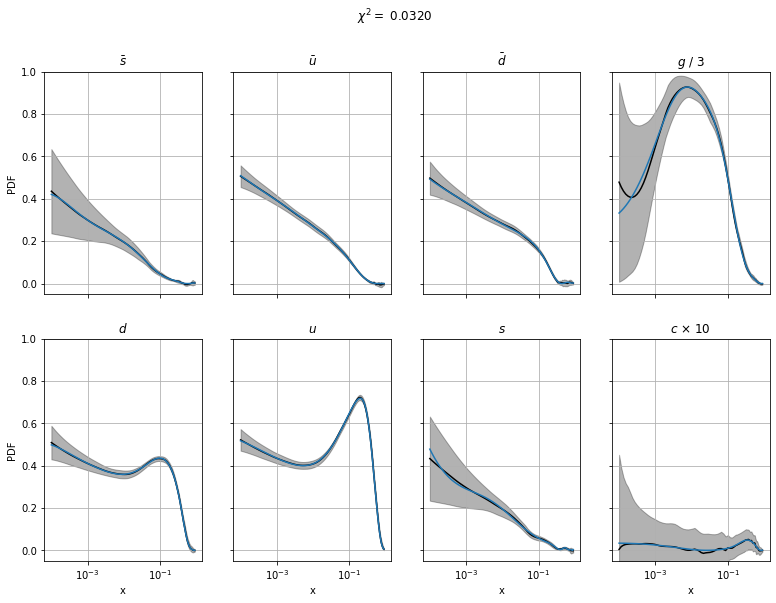

In [7]:
chi2 = loss(params)
paint_PDF(params, chi2)